<a href="https://colab.research.google.com/github/ritwikraha/CV-Practice/blob/master/Image_Inpainting_and_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Inpainting with Diffusers

In [1]:
!pip install diffusers -qq
!pip install accelerate -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.8 MB/s eta 0:00:00


In [23]:
!pip install kornia -qq
!pip install kornia_moons -qq
!pip install kornia_rs -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.1 MB/s eta 0:00:00


In [2]:
import PIL
import requests
import torch
import cv2
import kornia_moons
import numpy as np
import kornia as K
import kornia.feature as KF

from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as img


from PIL import Image
import torchvision.transforms as T
from kornia_moons.viz import draw_LAF_matches

from diffusers import AutoPipelineForInpainting

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# Create the pipelines
pipeline_sdxl_1 = AutoPipelineForInpainting.from_pretrained(
        "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
        torch_dtype=torch.float16,
    )
pipeline_sdxl_1 = pipeline_sdxl_1.to("cuda")


model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [4]:
# load base and mask image urls
img_url = "https://i.imgur.com/84JlFHp.png"
mask_url = "https://i.imgur.com/izAVzwj.png"

In [5]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

In [6]:
init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

In [8]:
prompt = "Side profile of the Hulk hitting a punch with his right hand, having an angry face and well defined features, comic book, modern day comics,illustration"
negative_prompt = "bad anatomy, deformed, ugly, disfigured"
image = pipeline_sdxl_1(prompt=prompt, negative_prompt=negative_prompt, image=init_image, mask_image=mask_image).images[0]

  0%|          | 0/49 [00:00<?, ?it/s]

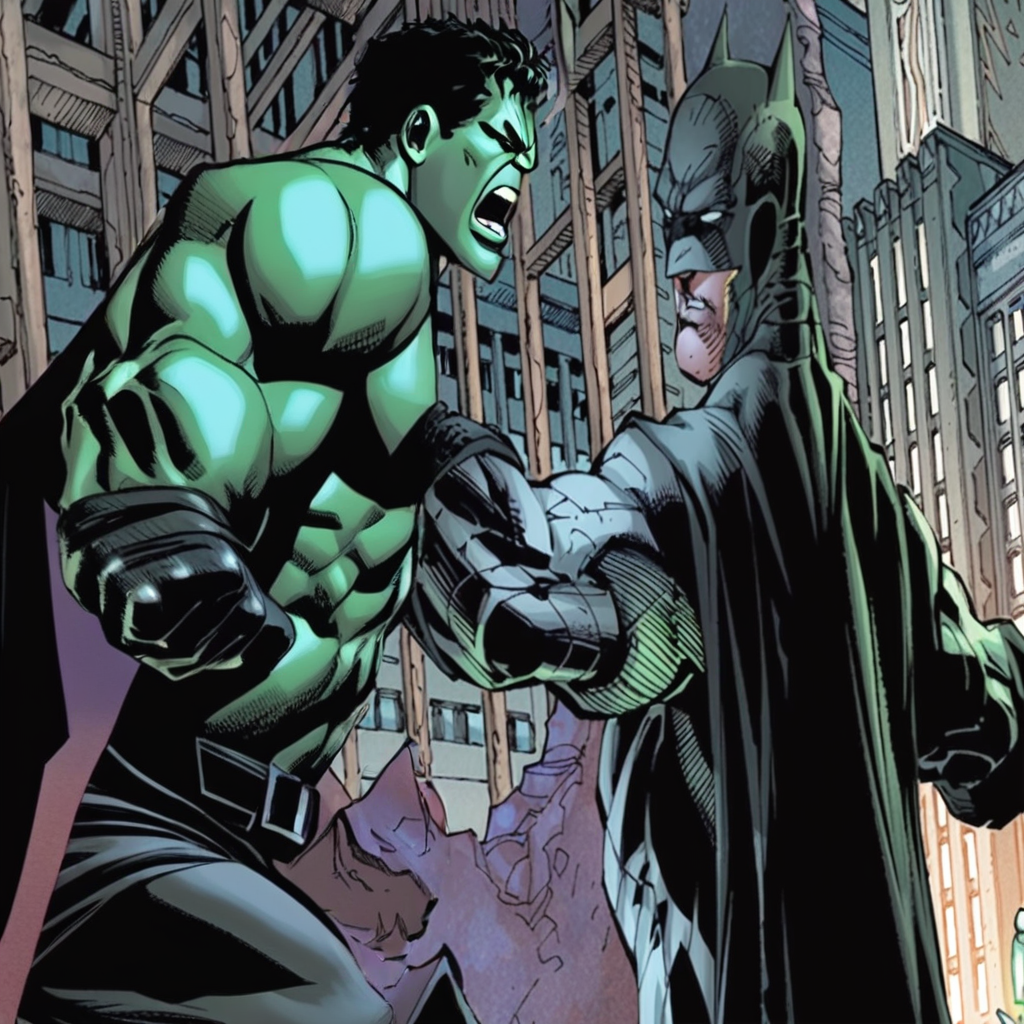

In [10]:
image

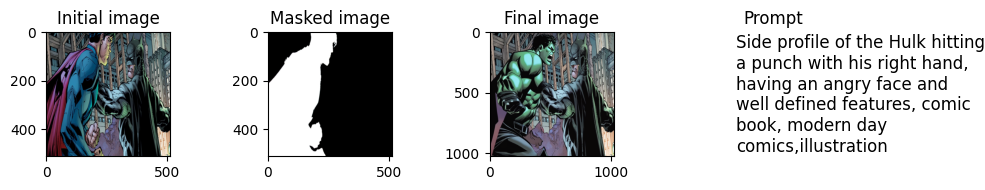

In [9]:
# Visualise the image, mask, inpainted image along  with the prompt

fig, ax = plt.subplots(1, 4, figsize=(10, 2))

ax[0].imshow(init_image)
ax[0].set_title('Initial image')

ax[1].imshow(mask_image)
ax[1].set_title('Masked image')

ax[2].imshow(image)
ax[2].set_title('Final image')

# Text box with word wrap
ax[3].text(0.76, 0.5, prompt, transform=fig.transFigure, horizontalalignment='left', verticalalignment='center', fontsize=12, wrap=True)
ax[3].set_title('Prompt')
ax[3].axis('off')  # Turn off axis



plt.tight_layout()
plt.show()

# Image Matching

Checking the density of image matching with LoFTR using the Kornia library.

In [33]:
# Convert PIL Image to Pytorch Tensor
def prepare_image_for_kornia(pil_image):

    # Check if the input is a valid PIL Image
    if not isinstance(pil_image, Image.Image):
        raise TypeError("The input must be a PIL Image.")

    # Transform the PIL image to a torch tensor and add batch dimension
    transform = T.Compose([
        T.ToTensor(), # Converts to a tensor and scales pixels to [0, 1]
    ])
    tensor_image = transform(pil_image).unsqueeze(0) # Add batch dimension

    return tensor_image

In [34]:
img1 = prepare_image_for_kornia(init_image)
img2 = prepare_image_for_kornia(image)

In [35]:
matcher = KF.LoFTR(pretrained="outdoor")

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

with torch.inference_mode():
    correspondences = matcher(input_dict)

In [36]:
for k, v in correspondences.items():
    print(k)

keypoints0
keypoints1
confidence
batch_indexes


In [37]:
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

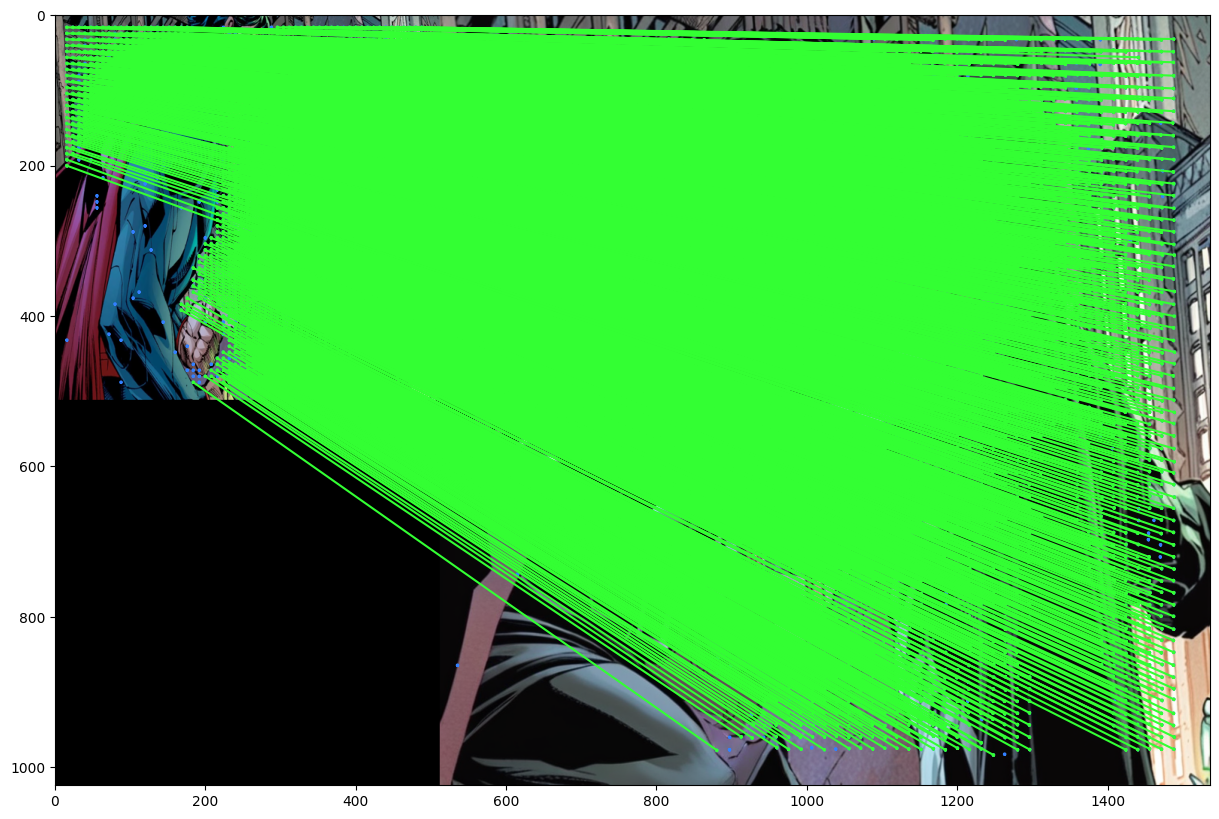

In [38]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": False},
)